### To Do:
    1. Functionalize data prep
    2. Define datasets, models, etc. in more organized way
    3. Set up a series of tests for a few architectures, learning rates, and feature sets
    4. Plot these results in an informative way (summary results, also example of best and worst outcome)

In [1]:
import torch
from torch import nn
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
from sqlalchemy import create_engine, event, Table, Column, Integer, String, DateTime, text, select, insert, and_, or_
from sqlalchemy.orm import sessionmaker,  DeclarativeBase, Mapped, mapped_column, relationship, Session
from sqlalchemy.ext.declarative import DeferredReflection
from typing import List, Optional
import datetime
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import re
import seaborn as sns
from unidecode import unidecode
import pyodbc
from sqlalchemy.engine import URL
import time
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from tqdm import tqdm, notebook, trange
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

playoff_url = "https://www.basketball-reference.com/playoffs/"

SERVER = 'localhost\SQLEXPRESS'
DRIVER = '{ODBC Driver 18 for SQL Server}'
# DRIVER = '{SQL Server}'
DATABASE = 'nba_standings'
USERNAME = 'OBA-NICHO11\Dalton'
PASSWORD = 'Endoneuro995350'
nba_standings_db_string = f'DRIVER={DRIVER};SERVER={SERVER};DATABASE={DATABASE};TrustServerCertificate=yes;Trusted_Connection=yes'
nba_standings_connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": nba_standings_db_string})


#### Grab NBA Standings and Advanced Stats from local (custom) database and prep features

Define data tables with SQLAlchemy

In [2]:
class Base(DeclarativeBase):
     pass

engine = create_engine(nba_standings_connection_url)

# @event.listens_for(Base.metadata, "column_reflect")
# def column_reflect(inspector, table, column_info):
#     column_info['name'] = column_info['name'].replace("%", "_percent")
#     column_info['name'] = column_info['name'].replace("/", "_per_")

class Standings(Base):
    __table__ = Table(
        "nba_standings",
        Base.metadata,
        Column("index", 
                Integer, 
                primary_key=True),
        autoload_with=engine,
    )

class AdvancedStats(Base):
    __table__ = Table(
        "nba_advanced_stats",
        Base.metadata,
        Column("index", 
                Integer, 
                primary_key=True),
        autoload_with=engine,
    )

Query Data

In [3]:
stmt = select(Standings
    ).order_by(Standings.Year.desc())

with engine.connect() as conn:
    standings_df = pd.read_sql(stmt, conn)

stmt = select(
    AdvancedStats
    ).order_by(AdvancedStats.Year.desc())
with engine.connect() as conn:
    stats_df = pd.read_sql(stmt, conn)

Fix team labels in both dataframes

In [4]:
stats_df.loc[stats_df['Tm'] == 'TOT', 'Tm'] = 'TOR' 
standings_df.loc[standings_df['Team'] == 'New Orleans Hornets', 'Team'] = 'New Orleans Pelicans'
standings_df.loc[standings_df['Team'] == 'Charlotte Bobcats', 'Team'] = 'Charlotte Hornets'
team_labels_dict = dict()
abbreviations = np.sort(stats_df.Tm.unique())
abbreviations[3:5] = abbreviations[4:2:-1]
for full_team_label, abbrev in zip(np.sort(standings_df.Team.unique()), abbreviations):
    team_labels_dict[full_team_label] = abbrev

standings_df.loc[:, 'Tm'] = [*map(team_labels_dict.get, standings_df['Team'])]

Convert numeric data columns to float, then remove years for which the database has no AdvancedStats data

In [5]:
for col in standings_df.columns:
    try:
        standings_df.loc[:, col] = standings_df.loc[:, col].astype(float)
    except:
        print(f'{col} could not be converted to float')


stats_df = stats_df.loc[(stats_df['USG%'].astype(float) > 0) & (stats_df['MP'].astype(float) > 48), :]
for col in stats_df.columns:
    try:
        stats_df.loc[:, col] = stats_df.loc[:, col].astype(float)
    except:
        print(f'{col} could not be converted to float')

standings_df = standings_df.loc[(standings_df.Year >= stats_df.Year.min()) & (standings_df.Year <= stats_df.Year.max()), :]

Team could not be converted to float
Playoffs could not be converted to float
Losing_season could not be converted to float
Tm could not be converted to float
Player could not be converted to float
Pos could not be converted to float
Tm could not be converted to float


Now I'll gather advanced stats for all the players for a team that played for a team in that year.

I identify the "Number 1 option" by the highest Usage Rate on the team, then the rest of the 5 "starters" by usage rate, then the rest of the team ("bench"). For the "starters" and "bench", I'll find the average of each statistic weighted by minutes played. 

In [6]:
stat_features = ['TS%', 'OBPM', 'DBPM', 'AST%', 'TOV%', 'VORP', 'PER', 'TRB%', '3PAr', 'FTr']
for st in stat_features:
    standings_df.loc[:, f'{st}_1']     = pd.Series().astype(float)
    standings_df.loc[:, f'{st}_start'] = pd.Series().astype(float)
    standings_df.loc[:, f'{st}_bench'] = pd.Series().astype(float)

In [7]:
def weighted_avg_by_MP(df, stat):
    return (df[stat] * df['MP']).sum() / df['MP'].sum()

for year, team in product(stats_df.Year.unique(), stats_df.Tm.unique()):
    team_players_stats = stats_df.loc[(stats_df.Year == year) & (stats_df.Tm == team), :].sort_values(by='USG%', ascending=False)
    for st in stat_features:
        standings_df.loc[(standings_df.Year == year) & (standings_df.Tm == team), f'{st}_1'] = team_players_stats[st].iloc[0]

        starters_df = team_players_stats.iloc[1:5]
        bench_df    = team_players_stats.iloc[5:]

        starters_wavg = weighted_avg_by_MP(starters_df, st)
        bench_wavg    = weighted_avg_by_MP(bench_df, st)

        standings_df.loc[(standings_df.Year == year) & (standings_df.Tm == team), f'{st}_start'] = starters_wavg
        standings_df.loc[(standings_df.Year == year) & (standings_df.Tm == team), f'{st}_bench'] = bench_wavg    


## Now I'll setup a pytorch model, train and evaluate

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

Set up Dataset class and a function for prepping test data for evaluation

In [9]:
class RegressionColumnarDataset(torch.utils.data.Dataset):
    def __init__(self, df_in, cats, df_y):

        self.dfcats  = df_in[cats] 
        self.dfconts = df_in.drop(cats, axis=1) #type: pandas.core.frame.DataFrame
        
        if self.dfcats.shape[-1] > 0:
            self.cats  = np.stack([col.values for n, col in self.dfcats.items()], axis=1).astype(np.int64)
        else:
            self.cats = np.full((df_in.shape[0], 1), np.nan) 
        if self.dfconts.shape[-1] > 0:
            self.conts = np.stack([col.values for n, col in self.dfconts.items()], axis=1).astype(np.float32)
        else:
            self.conts = np.full((df_in.shape[0], 1), np.nan) 
        self.y = df_y.values.astype(np.float32)
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

def prep_test_data(df_in, cats, df_y):
    
    dfcats  = df_in[cats] 
    dfconts = df_in.drop(cats, axis=1) #type: pandas.core.frame.DataFrame
    
    if dfcats.shape[-1] > 0:
        cats  = np.stack([col.values for n, col in dfcats.items()], axis=1).astype(np.int64)
    else:
        cats = np.full((df_in.shape[0], 1), np.nan) 
    if dfconts.shape[-1] > 0:
        conts = np.stack([col.values for n, col in dfconts.items()], axis=1).astype(np.float32)
    else:
        conts = np.full((df_in.shape[0], 1), np.nan) 
    y = df_y.values.astype(np.float32) 

    return cats, conts, y      


##### Prepare the Datasets for training and the true predictions for testing

In [10]:
features_list = [col for col in standings_df.columns if any([tag in col for tag in ['_1', '_start', 'bench']])]
output_list = ['W/L%']

scaler = StandardScaler()

test_years_df  = standings_df.loc[standings_df.Year == 2023, :] 
train_years_df = standings_df.loc[standings_df.Year != 2023, :]

train_features_df = pd.DataFrame(data = scaler.fit_transform(train_years_df[features_list].values), 
                                 columns = features_list)
test_features_df  = pd.DataFrame(data = scaler.fit_transform(test_years_df [features_list].values), 
                                 columns = features_list)

train_output_df = train_years_df[output_list]
true_winRate_df    = test_years_df [output_list]
cat_cols = []

X_train, X_val, y_train, y_val = train_test_split(train_features_df, train_output_df, test_size=0.20, random_state=42,shuffle=True)

train_dataset = RegressionColumnarDataset(X_train, cat_cols, y_train) 
val_dataset   = RegressionColumnarDataset(X_val, cat_cols, y_val) 

test_cats, test_conts, test_y = prep_test_data(test_features_df, cat_cols, true_winRate_df)
test_conts = torch.tensor(test_conts).cuda()

Set up DataLoaders for train and validation sets

In [11]:
train_params = {'batch_size': 32,
                'shuffle': True}
val_params = {'batch_size': 32,
              'shuffle'   : False}

train_dataloader = torch.utils.data.DataLoader(train_dataset, **train_params) 
val_dataloader   = torch.utils.data.DataLoader(  val_dataset, **val_params) 

## Create feedforward network

The full network model (FeedForwardNN) creates a feedforward network with hidden layers defined by the layer_size_list. For each linear hidden layer, I pass the outputs thru ReLU and BatchNormalization, then remove connections randomly with the nn.Dropout module. These last two steps help to regularize the model and prevent overfitting.

I also implement models without batch normalization, without dropout, and without either regularization method.

In [12]:
class FeedForwardNN(nn.Module):

    def __init__(self, n_cont, out_sz, layer_size_list, p=0.5):
        super().__init__()
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_in = n_cont
        
        for layer_units in layer_size_list:
            layerlist.append(nn.Linear(n_in,layer_units)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(layer_units))
            layerlist.append(nn.Dropout(p))
            n_in = layer_units
        layerlist.append(nn.Linear(layer_size_list[-1],out_sz))
            
        self.sequential_layers = nn.Sequential(*layerlist)
    
    def forward(self, x):
        x = self.bn_cont(x)
        x = self.sequential_layers(x)
        return x
    
class FeedForwardNN_no_batchNorm(nn.Module):

    def __init__(self, n_cont, out_sz, layer_size_list, p=0.5):
        super().__init__()        
        
        layerlist = []
        n_in = n_cont
        
        for layer_units in layer_size_list:
            layerlist.append(nn.Linear(n_in,layer_units)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.Dropout(p))
            n_in = layer_units
        layerlist.append(nn.Linear(layer_size_list[-1],out_sz))
            
        self.sequential_layers = nn.Sequential(*layerlist)
    
    def forward(self, x):
        x = self.sequential_layers(x)
        return x

class FeedForwardNN_no_dropout(nn.Module):

    def __init__(self, n_cont, out_sz, layer_size_list, p=0.5):
        super().__init__()        
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_in = n_cont
        
        for layer_units in layer_size_list:
            layerlist.append(nn.Linear(n_in,layer_units)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(layer_units))
            n_in = layer_units
        layerlist.append(nn.Linear(layer_size_list[-1],out_sz))
            
        self.sequential_layers = nn.Sequential(*layerlist)
    
    def forward(self, x):
        x = self.bn_cont(x)
        x = self.sequential_layers(x)
        return x
    
class FeedForwardNN_no_regularization(nn.Module):

    def __init__(self, n_cont, out_sz, layer_size_list, p=0.5):
        super().__init__()        
        
        layerlist = []
        n_in = n_cont
        
        for layer_units in layer_size_list:
            layerlist.append(nn.Linear(n_in,layer_units)) 
            layerlist.append(nn.ReLU(inplace=True))
            n_in = layer_units
        layerlist.append(nn.Linear(layer_size_list[-1],out_sz))
            
        self.sequential_layers = nn.Sequential(*layerlist)
    
    def forward(self, x):
        x = self.sequential_layers(x)
        return x

#### Training Function

In [13]:
def rmse(targ, y_pred):
   return np.sqrt(mean_squared_error(y_pred, targ))

def fit(model, train_dataloader, val_dataloader, loss_fn, opt, epochs=3, print_res=False):
    num_batch = len(train_dataloader)
    lr         = [[] for e in range(epochs)]
    tloss = [[] for e in range(epochs)] 
    vloss   = [[] for e in range(epochs)] 
    for epoch in trange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        for cat, cont, y in iter(train_dataloader):
            # cat  = cat.cuda()
            cont = cont.cuda()
            y    = y.cuda()
        
            opt.zero_grad()
            pred = model(cont)
            # pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward() # do backprop
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
                                    
            y_true_train     += list(y.cpu().data.numpy()*82)
            y_pred_train     += list(pred.cpu().data.numpy()*82)
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dataloader) # len train_dl = 704. the calc is number of train examples (89991) / batch size (128)
        
        if val_dataloader:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in iter(val_dataloader):
                # cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cont)
                # pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val     += list(y.cpu().data.numpy()*82)
                y_pred_val     += list(pred.cpu().data.numpy()*82)
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            val_acc = rmse(y_true_val, y_pred_val)
            val_loss = total_loss_val/len(val_dataloader)
            if print_res:
                print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {val_loss:.4f} val_rmse: {val_acc:.4f}')
        else:
            if print_res:
                print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

Set up a dict containing models and optimizers for a range of feedforward network models

In [14]:
models_dict = dict()

loss_function=nn.MSELoss()
dropout_p = 0.4
lr = 0.001
width_multipliers = [5, 10, 20]
arch_dict = dict(shallow          = [5, 2.5, 2.5],
                 medium           = [10, 5, 5, 5, 1],
                 deep             = np.repeat(5, 60),
                 bottleneckSmall  = [10, 5, 1, 0.5, 1, 5],
                 bottleneckLarge  = [100, 50, 10, 1, 0.5, 1, 5, 10]
                )
model_type_dict = dict(full   = FeedForwardNN, 
                       noBN   = FeedForwardNN_no_batchNorm, 
                       noDrop = FeedForwardNN_no_dropout, 
                       noReg  = FeedForwardNN_no_regularization)
                

for w_mult, (arch_key, arch), (model_key, model) in product(width_multipliers, arch_dict.items(), model_type_dict.items()):
    stored_key   = f'{arch_key}_scaled_by_{w_mult}_{model_key}_model'
    scaled_arch  = (np.array(arch)*w_mult).astype(int)
    stored_model = model(train_features_df.shape[1], 1, scaled_arch, p=dropout_p).to(device)
    stored_opt   = torch.optim.Adam(stored_model.parameters(), lr=lr) 
    models_dict[stored_key] = dict(scale         = w_mult,
                                   model         = stored_model,
                                   optimizer     = stored_opt,
                                   loss_function = loss_function)
    

##### Train all models and store the training and validation loss in the models_dict

In [15]:
for model_key, stored_model in models_dict.items():
    print(model_key,flush=True)
    epochs = 500 if 'deep' in model_key else 200 
    lr, train_loss, val_loss = fit(model=stored_model['model'], 
                                   train_dataloader=train_dataloader, 
                                   val_dataloader=val_dataloader, 
                                   loss_fn=stored_model['loss_function'], 
                                   opt=stored_model['optimizer'],  
                                   epochs=epochs)

    clear_output()

    t = [np.mean(train_loss[el]) for el in range(len(train_loss))]
    v = [np.mean(val_loss[el]) for el in range(len(val_loss))]

    stored_model['train_loss'] = t
    stored_model[  'val_loss'] = v

deep_scaled_by_10_noReg_model


 50%|████▉     | 249/500 [00:24<00:23, 10.52it/s]

Check train and validation loss for all the models (plots a single example plot for one model)

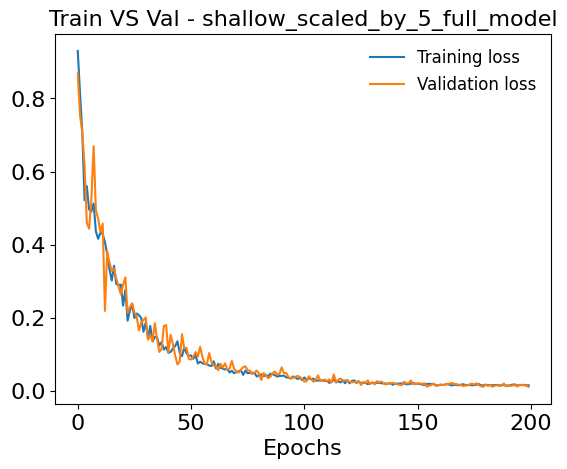

In [ ]:
ct = 0
for model_key, stored_model in models_dict.items():
    if ct > 0:
        break
    fig, ax = plt.subplots()
    ax.plot(stored_model['train_loss'], label='Training loss')
    ax.plot(stored_model[  'val_loss'], label='Validation loss')
    ax.set_title(f"Train VS Val - {model_key}")
    ax.set_xlabel("Epochs")
    ax.legend(frameon=False)
    plt.show()

    ct += 1

#### Evaluate each model on the held-out test data from 2023

In [ ]:
for model_key, stored_model in models_dict.items():
    stored_model['model'].eval()
    with torch.inference_mode():
        test_pred = stored_model['model'].forward(test_conts).cuda()
        test_pred = test_pred.cpu().data.numpy()
    
    stored_model['predictions'] = test_pred
    stored_model['rmse'] = rmse(true_winRate_df.values * 82, test_pred * 82)
    stored_model['correlation'] = pearsonr(np.squeeze(true_winRate_df.values) * 82, np.squeeze(test_pred * 82))[0]


c:\Users\Dalton\Documents\sql_practice\.conda\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Dalton\Documents\sql_practice\.conda\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Dalton\Documents\sql_practice\.conda\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Dalton\Documents\sql_practice\.conda\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Dalton\Documents\sql_practice\.conda\Li

RuntimeError: running_mean should contain 30 elements not 10

Put prediction data and labels in a dataframe and plot with seaborn

In [ ]:
arch_list = []
reg_list = []
scale_list = []
rmse_list = []
val_loss_list = []
corr_list = []
for model_key, stored_model in models_dict.items():
    key_parts = model_key.split('_')
    arch_list.append(key_parts[0])
    reg_list.append(key_parts[-2])
    scale_list.append(stored_model['scale'])
    rmse_list.append(stored_model['rmse'])
    val_loss_list.append(stored_model['val_loss'][-1])
    corr_list.append(stored_model['correlation'])

model_results_df = pd.DataFrame(data=zip(arch_list, reg_list, scale_list, rmse_list, val_loss_list, corr_list),
                                columns = ['Architecture', 'Regularization', 'Scale', 'RMSE', 'Validation Loss', 'Correlation'])


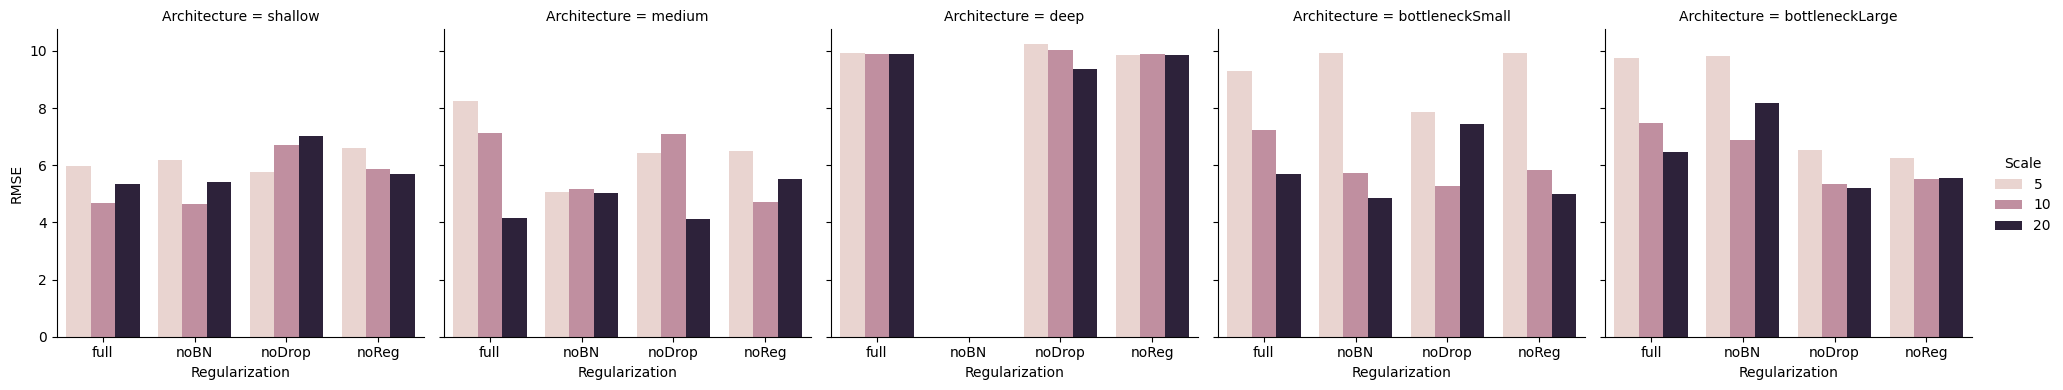

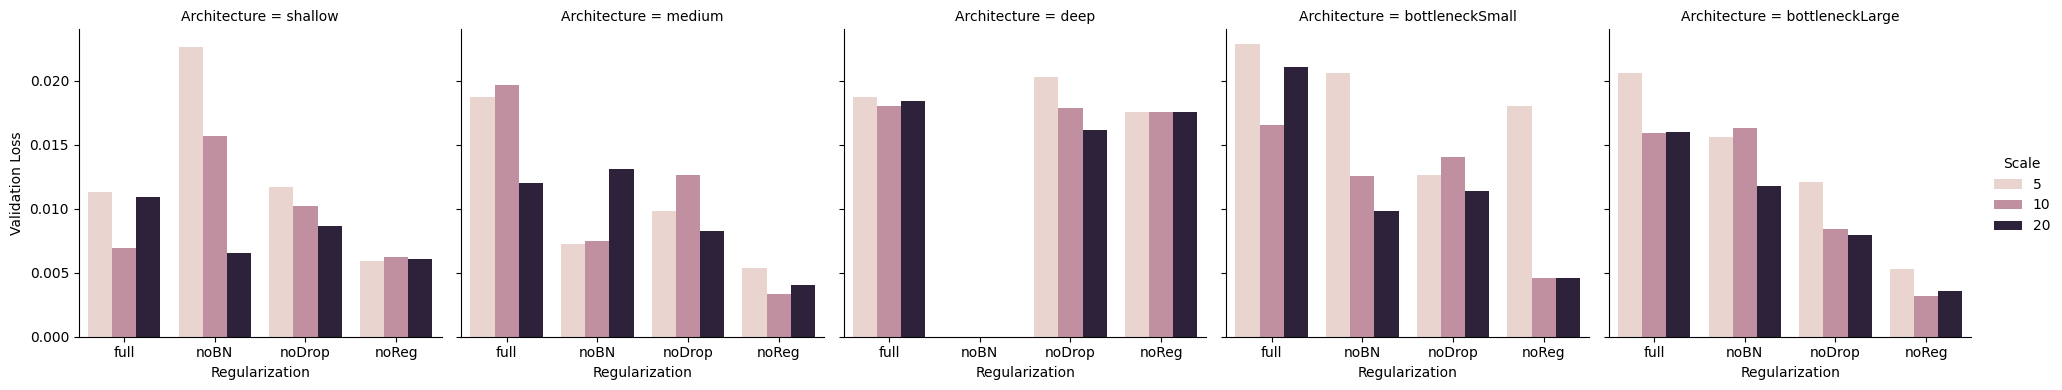

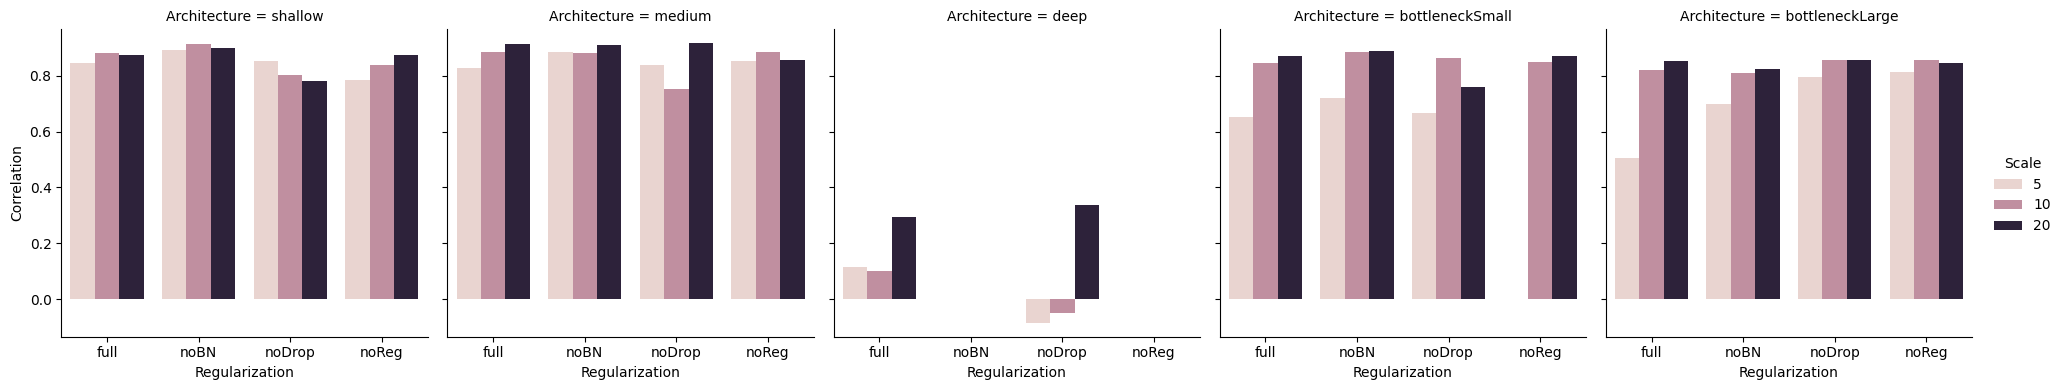

In [ ]:
sns.catplot(
    model_results_df.loc[~((model_results_df['Regularization'] == 'noBN') & (model_results_df['Architecture'] == 'deep')), :], kind="bar",
    x="Regularization", y="Validation Loss", hue='Scale', col="Architecture",
    height=4, aspect=1, 
)

sns.catplot(
    model_results_df.loc[~((model_results_df['Regularization'] == 'noBN') & (model_results_df['Architecture'] == 'deep')), :], kind="bar",
    x="Regularization", y="RMSE", hue='Scale', col="Architecture",
    height=4, aspect=1, 
)

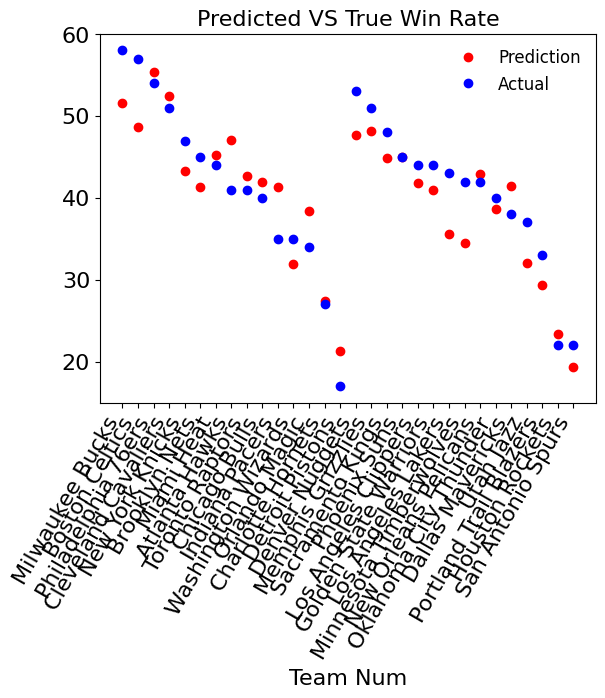

In [ ]:
best_model = models_dict['medium_scaled_by_20_noDrop_model']
# best_model = models_dict['bottleneckLarge_scaled_by_10_noReg_model']

plt.plot(best_model['predictions'] * 82, 'or', label='Prediction')
plt.plot(true_winRate_df.values * 82, 'ob', label='Actual')
plt.title("Predicted VS True Win Rate")
plt.xlabel("Team Num")
plt.xticks(range(true_winRate_df.shape[0]), test_years_df['Team'], rotation=60, ha='right')
plt.legend(frameon=False)


## Estimate importance of model inputs with Captum 

In [ ]:
model = best_model['model']

Linear(in_features=30, out_features=200, bias=True)

In [ ]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(test_conts, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(test_conts)
dl_attr_test = dl.attribute(test_conts)
gs_attr_test = gs.attribute(test_conts, torch.tensor(X_train.values).float().to(device))
fa_attr_test = fa.attribute(test_conts)

c:\Users\Dalton\Documents\sql_practice\.conda\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


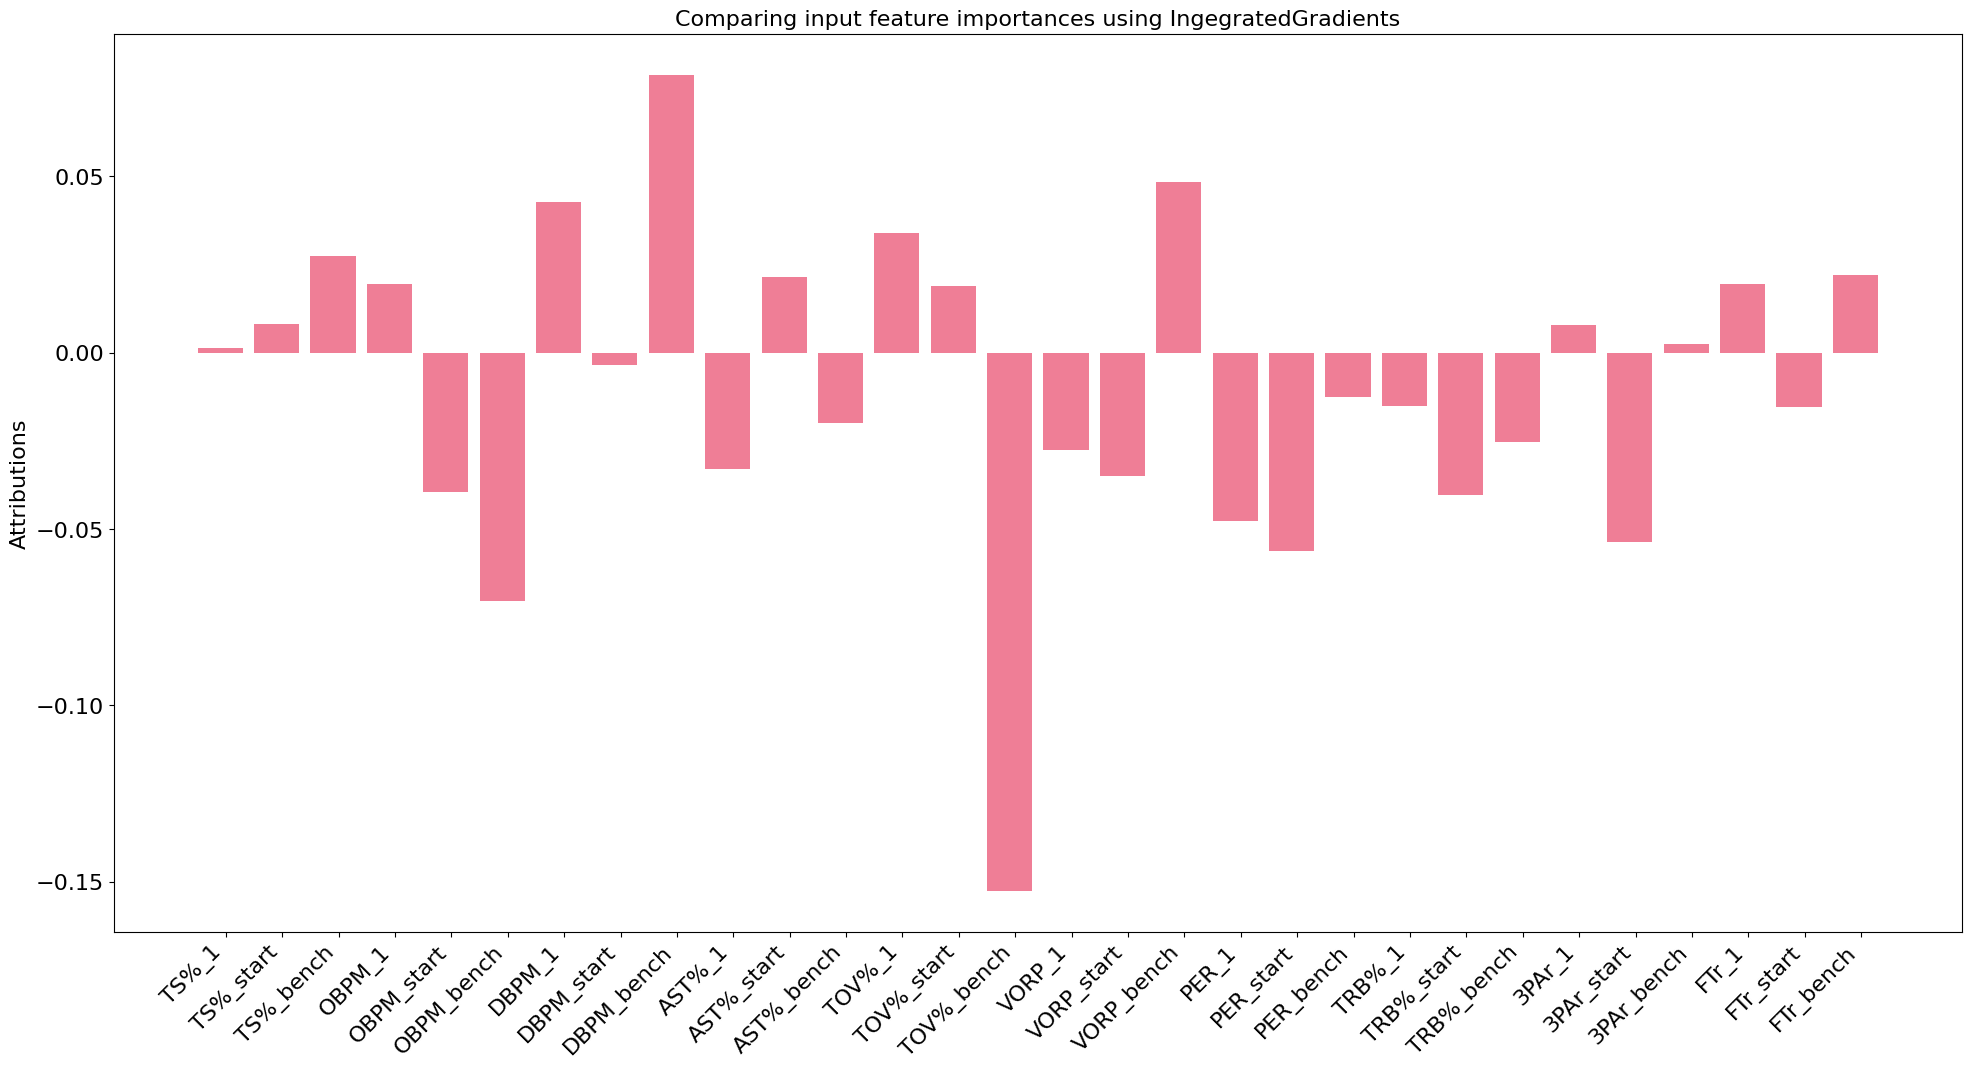

In [ ]:
x_axis_data = np.arange(train_features_df.shape[1])
x_axis_data_labels = list(map(lambda idx: train_features_df.columns[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().cpu().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

width = 0.14

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances using IngegratedGradients')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, alpha=0.8, align='edge', color='#eb5e7c')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels, rotation=45, ha='right')

plt.show()